<a href="https://colab.research.google.com/github/eunai9/datacreatorcamp/blob/main/2021_DATA_CREATOR_CAMP_10_02_Regression(k%EB%8C%80%EB%94%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*시작 전, 상단 메뉴 '파일' > '드라이브에 사본 저장' 을 선택하여 사본을 가지고 작업을 진행해주시기 바랍니다.*  

# 문제

> **Tom과 Sally는 신혼집을 구하는 중입니다. 그런데 집마다 조건과 가격이 너무 달라, 어떤 집이 좋은지 알기가 어렵습니다. Tom과 Sally가 적당한 조건과 가격의 신혼집을 구할 수 있도록, 머신러닝의 다양한 회귀(Regression) 기법들을 이용하여 집의 조건들을 가지고 가격을 예측하는 모델을 만들어주세요.**

# 데이터 및 목표
- 훈련 데이터(Train Data): 10525개의 집에 대한 20개의 feature와 target feature인 price
- 평가 데이터(Test Data): 4510개의 집에 대한 20개의 feature
- 피쳐 설명(Feature): 총 feature는 20개(price 제외) 이며, 예측해야 할 target feature는 **`price`** 입니다.
- 목표: Test Data의 price를 예측합니다.

# 평가 지표
- 예측값(Prediction) 과 실제값(Ground Truth) 간의 **`RMSE (Root Mean Squared Error)`** 를 사용합니다.
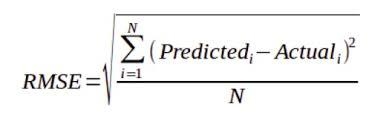
- RMSE는 0 이상의 값을 가지며, 작을수록 높은 성능을 의미합니다.

# 주의사항
- 팀별 submission 제출 가능 최대횟수는 **20번**입니다.
- 대회 종료 시각인 **PM 4:20** 까지만 제출이 가능합니다.
- submission 제출은 **각 팀별로 한 ID로만** 해주세요.

# EDA & Data Preprocessing

## Data fields
- `date` : 집을 구매한 날짜
- `price` : 집의 가격 (Target Feature)
- `bedrooms` : 침실의 수
- `bathrooms` : 화장실의 수
- `sqft_living` : 주거 공간의 평방 피트 (면적)
- `sqft_lot` : 부지의 평방 피트 (면적)
- `floors` : 집의 층 수
- `waterfront` : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- `view` : 집이 얼마나 좋아 보이는지의 정도
- `condition` : 집의 전반적인 상태
- `grade` : 특정 시스템 기준으로 매긴 집의 등급
- `sqft_above` : 지하실을 제외한 평방 피트 (면적)
- `sqft_basement` : 지하실의 평방 피트 (면적)
- `yr_built` : 지어진 년도
- `yr_renovated` : 집을 재건축한 년도
- `zipcode` : 우편번호
- `lat` : 위도
- `long` : 경도
- `sqft_living15` : 2015년 기준 주거 공간의 평방 피트 (면적, 집을 재건축했다면, 변화가 있을 수 있음)
- `sqft_lot15` : 2015년 기준 부지의 평방 피트 (면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import seaborn as sns
%matplotlib inline

import missingno as msno
from pandas.plotting import scatter_matrix
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
# plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
pd.set_option("display.max_columns", 30)

# 구글 드라이브 마운트

In [ ]:
# Google drive mount 
# link 들어가셔서 코드를 받은 뒤 'Enter verification code'에 입력하시면 됩니다.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 폴더 이동
import os
PATH = '/content/drive/MyDrive/Colab Notebooks/2021_data_creator_camp/data'  # 데이터와 ipynb파일이 있는 위치를 적으세요.
os.chdir(PATH)

## 데이터 불러오기

참고) id는 각 집의 고유번호입니다. 출제자가 랜덤으로 부여한 값이므로 집의 특성과 관련이 없습니다.

In [ ]:
train = pd.read_csv('train.csv')
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20150205T000000,539950.0,2,2.00,1670,3507,1.0,0,0,3,9,1670,0,2007,0,98029,47.5545,-122.003,2330,3889
1,1,20141124T000000,430000.0,3,2.25,2020,2750,2.0,0,0,3,8,1680,340,2008,0,98108,47.5633,-122.297,1720,1546
2,2,20150108T000000,760000.0,4,3.50,3000,5300,1.0,0,0,5,7,1780,1220,1949,0,98115,47.6748,-122.279,1360,5450
3,3,20141119T000000,355000.0,3,2.50,1810,3192,1.0,0,0,3,7,1070,740,2001,0,98019,47.7364,-121.969,1740,3720
4,4,20150407T000000,705000.0,4,3.25,2740,5339,2.5,0,0,3,9,2740,0,2004,0,98103,47.6706,-122.356,1770,4820


In [ ]:
test = pd.read_csv('test.csv')
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10525,20150406T000000,4,2.50,2420,18470,1.0,0,0,3,8,920,1500,1968,0,98005,47.6001,-122.176,2690,13800
1,10526,20141202T000000,2,1.00,950,4560,1.5,0,0,3,7,950,0,1925,0,98112,47.6288,-122.300,2040,4560
2,10527,20140702T000000,5,2.25,2570,13054,1.0,0,1,3,8,1470,1100,1950,1992,98166,47.4487,-122.352,2570,19807
3,10528,20150428T000000,1,1.00,620,8685,1.0,0,0,4,5,620,0,1976,0,98198,47.4095,-122.290,1300,12150
4,10529,20140819T000000,4,2.50,2650,6240,2.0,0,0,3,8,2650,0,2013,0,98053,47.6885,-122.021,2640,6524


In [ ]:
print('train shape: {}\ntest shape: {}'.format(train.shape, test.shape))

train shape: (10525, 21)
test shape: (4510, 20)


train set은 (10525행, 21열) 로,  
test set은 (4510행, 20열) 로 이루어져 있습니다.  
로드된 데이터의 shape이 이와 다르다면 잘못 로드된 것이니 다시 로드해보세요.

In [ ]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## 결측치 확인

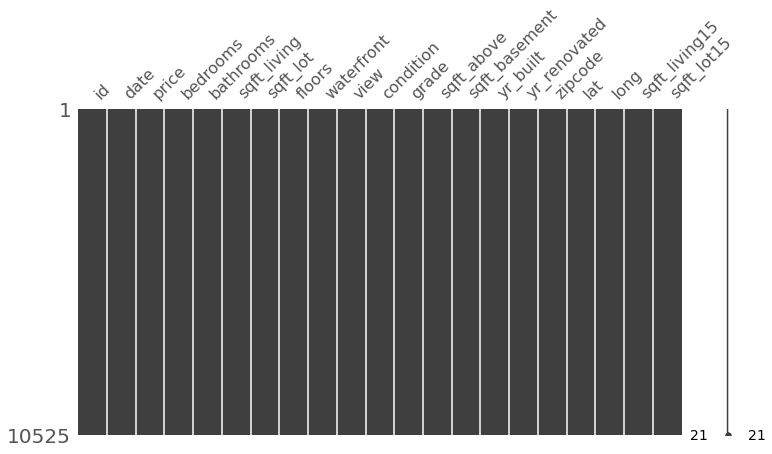

In [ ]:
msno.matrix(train, figsize=(12,6))

- 모든 변수에 결측치가 존재하지 않습니다.

## 전체적인 데이터 둘러보기

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10525 entries, 0 to 10524
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10525 non-null  int64  
 1   date           10525 non-null  object 
 2   price          10525 non-null  float64
 3   bedrooms       10525 non-null  int64  
 4   bathrooms      10525 non-null  float64
 5   sqft_living    10525 non-null  int64  
 6   sqft_lot       10525 non-null  int64  
 7   floors         10525 non-null  float64
 8   waterfront     10525 non-null  int64  
 9   view           10525 non-null  int64  
 10  condition      10525 non-null  int64  
 11  grade          10525 non-null  int64  
 12  sqft_above     10525 non-null  int64  
 13  sqft_basement  10525 non-null  int64  
 14  yr_built       10525 non-null  int64  
 15  yr_renovated   10525 non-null  int64  
 16  zipcode        10525 non-null  int64  
 17  lat            10525 non-null  float64
 18  long  

In [ ]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,10525.000000,1.052500e+04,10525.000000,10525.000000,10525.000000,1.052500e+04,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000,10525.000000
mean,5262.000000,5.380466e+05,3.366366,2.106366,2073.974252,1.544489e+04,1.493112,0.006936,0.227363,3.406271,7.650546,1787.454537,286.519715,1970.919240,86.511544,98078.058052,47.562216,-122.213079,1986.849121,12836.911734
std,3038.450126,3.598138e+05,0.898249,0.764644,903.692598,4.470121e+04,0.537217,0.082996,0.754747,0.644008,1.168147,821.594426,434.731368,29.435286,406.553777,53.437415,0.138280,0.141896,687.272667,27756.532496
min,0.000000,8.300000e+04,0.000000,0.000000,380.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,380.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.515000,399.000000,659.000000
25%,2631.000000,3.220000e+05,3.000000,1.500000,1430.000000,5.029000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.474900,-122.328000,1490.000000,5100.000000
50%,5262.000000,4.500000e+05,3.000000,2.250000,1900.000000,7.622000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.573600,-122.231000,1840.000000,7620.000000
75%,7893.000000,6.450000e+05,4.000000,2.500000,2550.000000,1.063900e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98117.000000,47.680000,-122.126000,2350.000000,10083.000000
max,10524.000000,7.700000e+06,10.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8570.000000,3480.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


- 변수 별 scale이 매우 다르므로 scale에 민감한 알고리즘을 사용할 때는 scaling이 필요함을 알 수 있습니다.

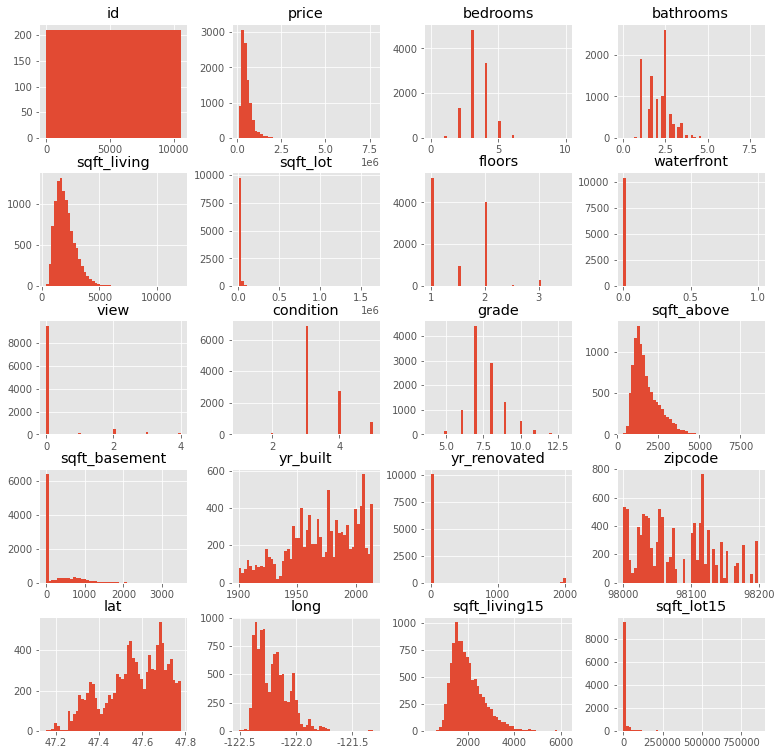

In [ ]:
train.hist(bins=50, figsize=(13,13))
plt.show()

- 몇몇 변수들은 한쪽에 치우친 분포를 보이니 log 변환 등을 통해 분포를 맞춰주는 것도 매우 좋은 방법입니다.

In [ ]:
attributes = ['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'bedrooms']
scatter_matrix(train[attributes], figsize=(12,10))
plt.show()

- 서로 높은 상관관계가 있는 것으로 보이는 변수들이 존재합니다.    
- price과 sqft_living, sqft_above, sqft_living15, bathrooms
- sqft_living과 price, grade, sqft_above, sqft_living15, bathrooms 등입니다.  

그럼 변수별 상관계수를 확인해 보겠습니다.

## 변수별 상관관계

In [ ]:
train.info()

In [ ]:
columns = list(train.columns)
print(columns)

In [ ]:
corr_matrix = train[columns].corr()
corr_matrix

In [ ]:
corr_matrix['price'].sort_values(ascending=False)

- price와의 상관관계는
- sqft_living, grade, sqft_above가 0.6~0.7 정도,
- sqft_living15, bathrooms는 0.5~0.6 정도를 띱니다. 
- 그러나 카테고리형도 있고, scaling도 되어있지 않으므로 이걸로만 상관관계를 판단할 수는 없습니다.  

In [ ]:
sns.heatmap(round(corr_matrix,1), annot=True)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

heatmap을 이용하면 변수별 상관관계를 더 뚜렷하게 볼 수 있습니다.

## 변수별 EDA 및 Preprocessing

### price

In [ ]:
sns.distplot(train['price'], hist=True)
plt.show()

- price가 0에서 1000000 사이에 몰려있으므로 log변환을 통해 예쁜 정규분포 모양을 만들어 봅시다.

In [ ]:
# log 변환 
train['log_price'] = np.log1p(train['price'])

In [ ]:
sns.distplot(train['log_price'], hist=True)
plt.show()

- 아까보다 훨씬 예쁜 종 모양의 분포가 만들어졌습니다.

distplot을 보면, 유난히 가격이 큰 집들이 존재합니다. 어떤 집인지 살펴보겠습니다.

In [ ]:
sns.boxplot(train.log_price)

몇몇 이상치들이 존재하는 것을 볼 수 있습니다.  
그렇다면 이 중 log_price가 11.5 이상 14.5 이하인 집들만 가지고 box plot을 그려보겠습니다.

In [ ]:
sns.boxplot(train[(train.log_price <= 14.5) & (train.log_price >= 11.5)].log_price)

아까보다 훨씬 예쁜 boxplot이 그려진 것 같습니다.  
제외했던 이상치가 몇 개인지 확인해보겠습니다.

In [ ]:
train[(train.log_price < 11.5) | (train.log_price > 14.5)]  # 11.5 미만 14.5 초과인 집들만 확인

In [ ]:
104 / train.shape[0] * 100

104개입니다. 즉 전체 데이터의 0.98%입니다. 이 집들은 너무 심한 이상치로 판단되므로 제거해 보겠습니다.

In [ ]:
train.drop(train[(train.log_price < 11.5) | (train.log_price > 14.5)].index, axis=0, inplace=True)

In [ ]:
sns.distplot(train.log_price)

In [ ]:
sns.boxplot(train.log_price)

아까보다 훨씬 예쁜 분포가 된 것을 볼 수 있습니다.

In [ ]:
columns.append('log_price')

In [ ]:
train[columns].corr()['log_price'].sort_values(ascending=False)

In [ ]:
train.shape

train set이 이제 10421행이 되었습니다.

### bedrooms

In [ ]:
train.bedrooms

카테고리형으로 보입니다. 분포를 알아봅시다.

In [ ]:
train.bedrooms.value_counts().sort_index()

0        3
1       84
2     1328
3     4830
4     3310
5      714
6      122
7       16
8        8
9        4
10       2
Name: bedrooms, dtype: int64

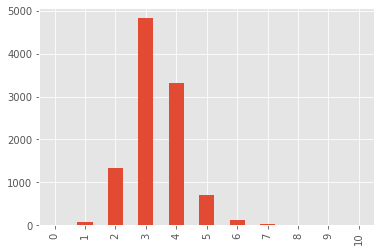

In [ ]:
train.bedrooms.value_counts().sort_index().plot(kind='bar')

bedrooms=0, 7, 8, 9, 10인 집들은 적다고 판단되므로 제거해 보겠습니다.

In [ ]:
train[(train.bedrooms <= 0) | (train.bedrooms >= 7)].shape

(33, 22)

총 33개의 집이 해당됩니다.

In [ ]:
train.drop(train[(train.bedrooms <= 0) | (train.bedrooms >= 7)].index, axis=0, inplace=True)

In [ ]:
train.shape

(10388, 22)

In [ ]:
train.bedrooms.value_counts().sort_index()

1      84
2    1328
3    4830
4    3310
5     714
6     122
Name: bedrooms, dtype: int64

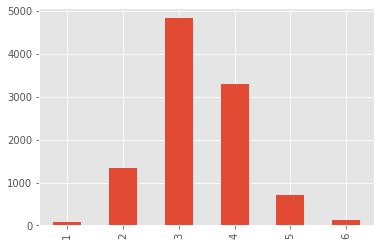

In [ ]:
train.bedrooms.value_counts().sort_index().plot(kind='bar')

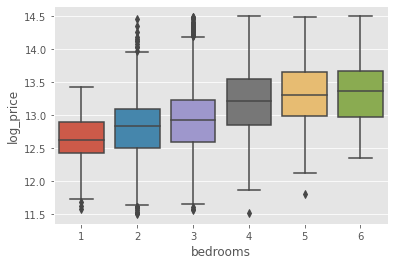

In [ ]:
sns.boxplot(x='bedrooms', y='log_price', data=train)

이외에도 boxplot에서 가장 심한 이상치들로 보이는 집들을 제거하는 것도 좋은 방법입니다.

### waterfront

In [ ]:
train.waterfront.value_counts().sort_index()

0    10336
1       52
Name: waterfront, dtype: int64

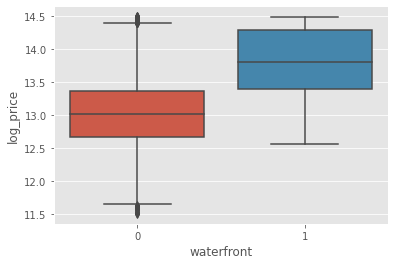

In [ ]:
sns.boxplot(x='waterfront', y='log_price', data=train)

0인 집이 훨씬 많지만, 1인 집들이 전반적으로 price가 높은 양상을 보여줍니다.

### condition-grade

In [ ]:
train.condition.value_counts()

3    6801
4    2747
5     790
2      70
1      13
Name: condition, dtype: int64

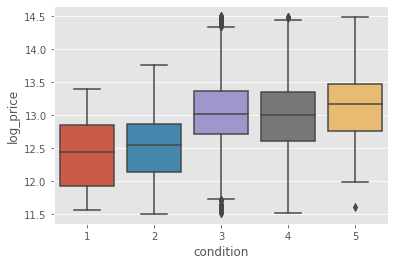

In [ ]:
sns.boxplot(x='condition', y='log_price', data=train)

1,2일 때와 3,4,5일때로 분리되는 것 같은데 1,2condition을 따로 체크하는 피처를 만들면 어떨까? bad_condition 이렇게

In [ ]:
train.grade.value_counts().sort_index()

4       14
5      117
6      986
7     4410
8     2908
9     1294
10     516
11     152
12      24
Name: grade, dtype: int64

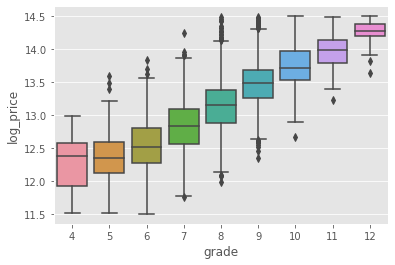

In [ ]:
sns.boxplot(x='grade', y='log_price', data=train)

grade가 확실히 price와 연관성이 있음

In [ ]:
train[columns].corr()['condition']['grade']

-0.15864761855592788

### 지하실

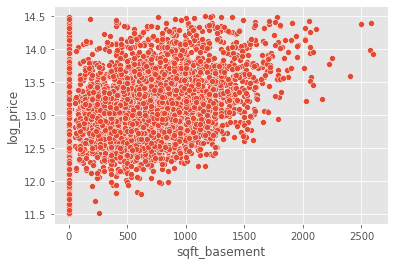

In [ ]:
sns.scatterplot(x='sqft_basement', y='log_price', data=train)

대략 이런 방식으로 변수들을 하나씩 살펴보며 판단에 따라 데이터를 정제하면 됩니다.  
본 코드에 적혀있는 전처리 방법들을 똑같이 적용할 필요는 없습니다. 예시일 뿐이니 자유롭게 변경하셔도 됩니다.

# Feature Engineering

지금까지 3가지 변수 (price, bedrooms, waterfront)에 대하여 간단한 EDA 및 Data Preprocessing을 진행하였습니다.  
이제는 간단한 Feature Engineering을 진행해보겠습니다.

Feature Engineering은 모델 정확도를 높이기 위해서 주어진 데이터를 예측 모델의 문제를 잘 표현할 수 있는 변수들로 변형시키는 과정입니다.  
'머신러닝 알고리즘을 작동하기 위해 데이터의 도메인 지식을 활용해 변수들을 만드는 과정'이라고도 할 수 있습니다.  
이 과정은 머신러닝 학습 과정에서도 흔히 가장 중요하다고 알려져 있습니다.  
얼마나 유의한 변수들을 만들어 내는지에 따라 모델의 성능이 크게 달라지기 때문입니다.  
다양한 관점과 아이디어를 통해 여러 변수들을 고민해보세요.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
# plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
pd.set_option("display.max_columns", 30)

import missingno as msno
from pandas.plotting import scatter_matrix
import math
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
# plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
pd.set_option("display.max_columns", 30)

In [ ]:
list(train.columns)

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'log_price']

다음은 간단한 Feature Engineering 예시입니다.

## rooms 생성: bedrooms+bathrooms

In [ ]:
for data in [train,test]:
    data['rooms'] = data['bedrooms'] + data['bathrooms']

## 재건축된지 얼마나 됐는지

In [ ]:
after_renovation = []

for yr_built, yr_renovated,year in zip(train['yr_built'].values, train['yr_renovated'].values, train['year'].values):
  if yr_renovated == 0: after_renovation.append(year - yr_built)
  else: after_renovation.append(year - yr_renovated)

train['after_renovation'] = after_renovation

after_renovation = []

for yr_built, yr_renovated,year in zip(test['yr_built'].values, test['yr_renovated'].values, test['year'].values):
  if yr_renovated == 0: after_renovation.append(year - yr_built)
  else: after_renovation.append(year - yr_renovated)

test['after_renovation'] = after_renovation

## renovated_bn 생성: 재건축 유무(1-유, 0-무)

In [ ]:
for data in [train,test]:
    data['renovated_bn'] = list(map(lambda x: 1 if x !=0 else 0, data['yr_renovated']))

## basement_bn 생성: 지하실 유무

In [ ]:
for data in [train,test]:
    data['basement_bn'] = list(map(lambda x: 1 if x !=0 else 0,data['sqft_basement']))

## date_int 생성: YYYYMM 형태의 int 타입

In [ ]:
for data in [train,test]:
    data['date_int'] = data.date.str.slice(0, 6).astype(int)

## year, month 생성

In [ ]:
for data in [train,test]:
    data['year'] = data.date_int.map(lambda x: int(str(x)[:4]))
    data['month'] = data.date_int.map(lambda x: int(str(x)[4:]))

## sqft_living_per_floor, sqft_living15_per_floor, sqft_above_per_floor 생성: 층당 면적

In [ ]:
for data in [train,test]:
    data['sqft_living_per_floor'] = data['sqft_living'] / data['floors']
    data['sqft_living15_per_floor'] = data['sqft_living15'] / data['floors']
    data['sqft_above_per_floor'] = data['sqft_above'] / data['floors']

##scailing

In [ ]:
train_df = train.drop(['id','price', 'date', 'sqft_living', 'sqft_lot', 'waterfront', 'yr_built',	'yr_renovated',	'zipcode',	'lat',	'long', 'log_price'	], axis=1)
test_df = test.drop(['id', 'date', 'sqft_living', 'sqft_lot', 'waterfront', 'yr_built',	'yr_renovated',	'zipcode',	'lat',	'long'	], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df)
train_scaled = scaler.transform(train_df)
test_scaled = scaler.transform(test_df)#테스트, 트레인데이터 스탠다드 스케일링 완료

In [ ]:
train[list(train_df.columns)]= train_scaled

In [ ]:
test[list(test_df.columns)]= test_scaled

이외에도 정말 다양한 변수들을 만들어낼 수 있습니다.

In [ ]:
train.head()

# Modeling

피쳐 엔지니어링 과정이 끝났다면,  
모델링 과정에서는 다양한 모델들을 활용하여 train 데이터를 학습하고 학습된 모델로 test 데이터의 답을 예측합니다.  
오늘 주어진 문제는 '집값 예측'이므로 다양한 회귀 모델을 사용하시면 됩니다.  
모델의 성능은 test 데이터에 대한 RMSE로 평가됩니다.  
TIP: 한 가지 모델만 사용하지 않고, 여러 모델을 사용하여 예측 결과들을 앙상블(ex. 평균)하는 것이 훨씬 좋은 결과를 얻을 수 있습니다.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", 100)
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import seaborn as sns
%matplotlib inline

import missingno as msno
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

np.random.seed(1120)

In [ ]:
train.shape

In [ ]:
test.shape

여기까지 진행했을 때, price에 log 변환만 수행했을 경우 train과 test의 column 수가 2만큼 차이나는 것이 정상입니다.  
target feature(price, log_price)가 test에는 없기 때문입니다.  
만약 아니라면 전처리 및 feature engineering 부분에서 train과 test에 모두 동일한 작업을 수행했는지 확인해보세요.

In [ ]:
train.columns

In [ ]:
test.columns

In [ ]:
# 모델을 학습할 때 사용할 변수들을 선택합니다. 자유롭게 변경하여 학습해보세요.
FEATURE_SELECT = [
 'bedrooms',
 'bathrooms',
 'sqft_living15',
 'sqft_lot15',
 'waterfront',
 'floors',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement'
]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train[FEATURE_SELECT],  # 학습할 때 사용할 변수들입니다.
                                                   train['log_price'],    # 예측할 타겟 변수입니다.
                                                   test_size=0.2,         # train data의 1/5를 validation data로 사용합니다.
                                                   random_state=1120)

## 모델사용

In [ ]:
#XGB
model_xgb = xgb.XGBRegressor(random_state=1120, metric='rmse') 
model_xgb.fit(X_train, y_train)
y_pred_xgb = np.expm1(model_xgb.predict(X_val))
score = np.sqrt(mse(np.expm1(y_val), y_pred_xgb))
print('XGB RMSE 값: {0:.4f}'.format(score))

In [ ]:
# LGBM
model_lgb = lgb.LGBMRegressor(random_state=1120, metric='rmse')
model_lgb.fit(X_train, y_train)
y_pred_lgb = np.expm1(model_lgb.predict(X_val))
score = np.sqrt(mse(np.expm1(y_val), y_pred_lgb))
print('LGBM RMSE 값: {0:.4f}'.format(score))

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

model_ridge=Ridge(alpha=10)
model_ridge.fit(X_train, y_train)
y_pred_ridge=np.expm1(model_ridge.predict(X_val))
score = np.sqrt(mse(np.expm1(y_val), y_pred_ridge))
print('Ridge RMSE 값: {0:.4f}'.format(score))

## submission

모델이 잘 학습된 것 같다면, 이제 test 데이터에 대해 예측할 차례입니다.

In [ ]:
test['price'] = np.expm1(model_xgb.predict(test[FEATURE_SELECT]))
test

### 예측결과 제출

test 데이터에 대한 price 예측값이 생성된 것을 확인할 수 있습니다.  
마지막으로, test 데이터의 price를 csv 파일로 저장하여 Kaggle Competition 페이지에 제출하시면 됩니다.  
고생하셨습니다. :)

In [ ]:
# submission 파일을 저장할 폴더 만들기
SAVE_PATH = os.path.join(PATH, "output")
if not os.path.exists(SAVE_PATH):
  os.mkdir(SAVE_PATH)
else:
  pass

In [ ]:
submission = test[['id', 'price']]  # 제출 submission에는 반드시 id, price 두 컬럼만 들어가야 합니다. 
submission.shape

제출 전, 생성된 submission이 총 (4510행, 2열) 의 형태로 이루어져 있는지 꼭 확인하세요.  
개수가 맞지 않으면 채점이 되지 않습니다.

In [ ]:
team = "showmethemoney"  # 반드시 팀명을 적어주세요.

# 이 밑은 수정하지 마세요.
from datetime import datetime
timestamp = datetime.today().strftime("%Y%m%d%H%M%S")
submission.to_csv(os.path.join(SAVE_PATH, f'./{team}_{timestamp}.csv'), index=False)
print(f"디렉토리 'output'에 파일 '{team}_{timestamp}.csv' 저장 완료!")